# MONAI Multi Channel Dataloaders


This notebook will introduce users to write custom dataloaders in MONAI for multichannel images. In this example we use 6 channel non composite microscopy images as an example.

Reference: https://www.rxrx.ai/rxrx1#the-data

### Overview

In this tutorial we will be going through the following steps:

* Download a dataset for training and testing
* Use the custom dataloader to load the 6 channel images
* Use PyTorch ResNext for classification (extendible to other frameworks and models)
* Train the model 
* Test and evaluate model performace on the testing data

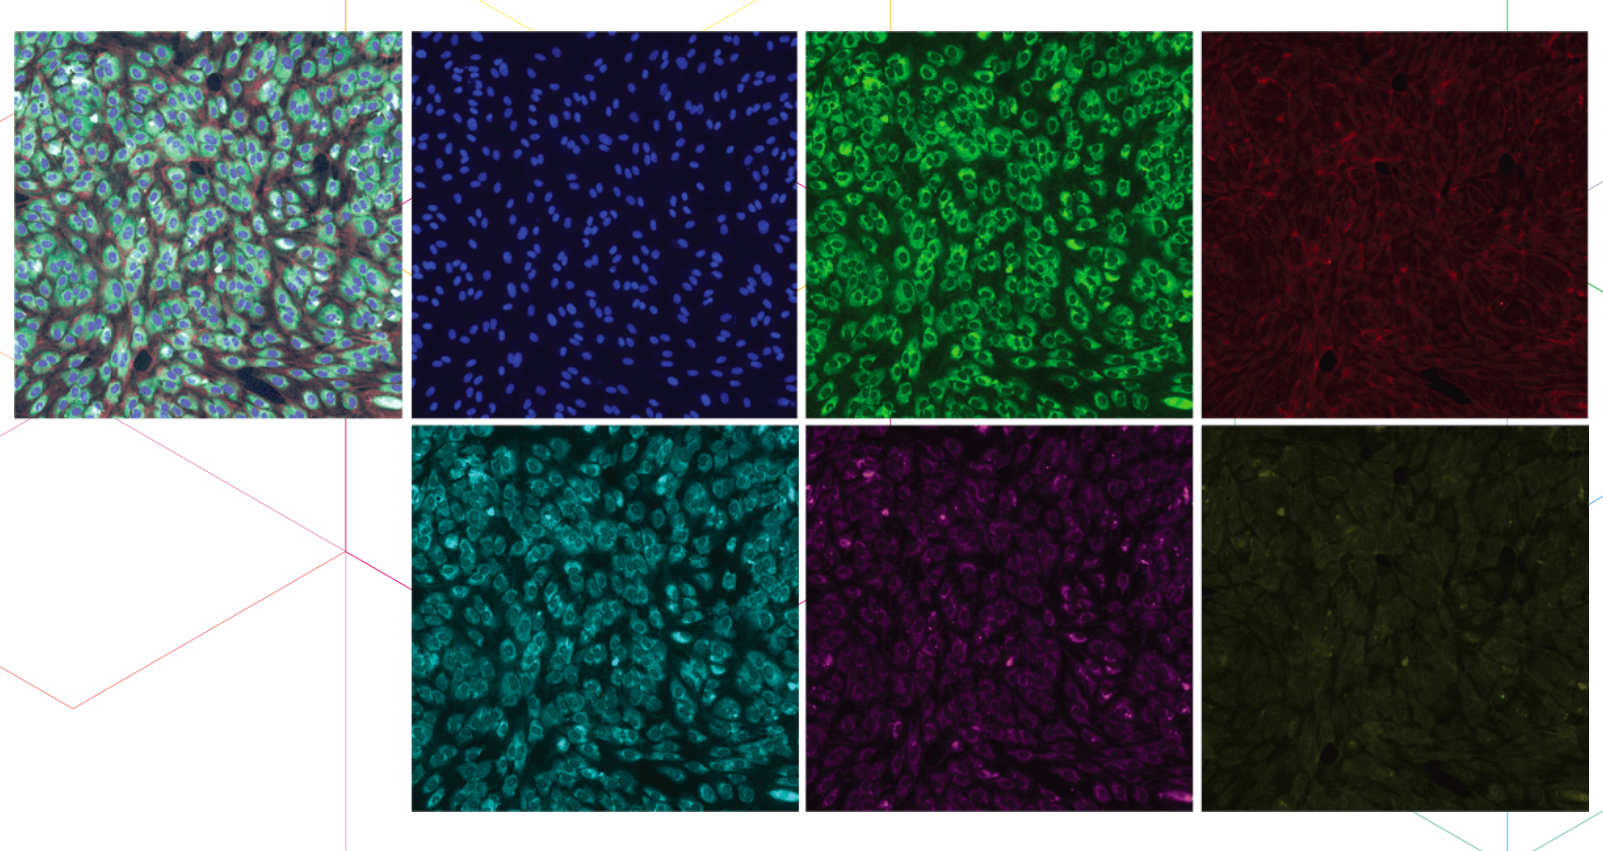

*Image Credits: RECURSION*

### Setting up the environment:

Installing dependencies

In [1]:
#!pip install -r https://raw.githubusercontent.com/Project-MONAI/MONAI/dev/requirements-dev.txt

### Setting up imports:

In [2]:
import os
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from argparse import ArgumentParser

import torch
from torchmetrics.functional import f1_score
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn import preprocessing
from torchvision import transforms as T
import torchvision

import warnings
warnings.filterwarnings('ignore')
from monai.utils import set_determinism
import monai.data as D

/drives/rocket2tb/projects/aastha/RXRX1/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checking the GPU specifications and verify the kind of hardware you have access to

In [3]:
!nvidia-smi

Fri Oct  7 14:29:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:09:00.0  On |                    0 |
| 30%   43C    P5    83W / 300W |    162MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download the Dataset

Download the metadata and the images: https://www.rxrx.ai/rxrx1#Download

In [4]:
#!wget https://storage.googleapis.com/rxrx/rxrx1/rxrx1-images.zip
#!unzip rxrx1-images.zip

### Custom MONAI Data Loader

Motivation: To make it easier to load non composite multichannel image dataset

In [5]:
class ImagesDS(D.Dataset):
    def __init__(self, csv_file, img_dir, mode='train', channels=[1,2,3,4,5,6]):
        
        df = pd.read_csv(csv_file)
        self.records = df.to_records(index=False)
        self.channels = channels
        self.mode = mode
        self.img_dir = img_dir
        self.len = df.shape[0]
    
    def _load_img_as_tensor(self, file_name, index):
        with Image.open(file_name) as img:
            return T.ToTensor()(img)


    def _get_img_path(self, index, channel):
        # This is specific to the features in the RXRX1 dataset
        experiment, well, plate, site = self.records[index].experiment, self.records[index].well, self.records[index].plate, self.records[index].site
        if self.mode!='val':
            return '/'.join([self.img_dir,self.mode,experiment,f'Plate{plate}',f'{well}_s{site}_w{channel}.png'])
        else:
            return '/'.join([self.img_dir,'train',experiment,f'Plate{plate}',f'{well}_s{site}_w{channel}.png'])
        
    def __getitem__(self, index):
        paths = []
        flag = 1
        for ch in self.channels:
            img_path = self._get_img_path(index, ch)
            if os.path.exists(img_path):
                paths.append(img_path)
            else:
                flag = 0
        if flag:
            img = torch.cat([self._load_img_as_tensor(img_path, index) for img_path in paths])
            label = self.records[index].sirna
            return img, label                

    def __len__(self):
        return self.len

### Encoding the labels to make the values contiguous

In [6]:
def dictionary(args):
    # Replace '/train-meta.csv' with your train csv
    df_train = pd.read_csv(args.path + "/train-meta.csv")
    le = preprocessing.LabelEncoder()
    df_train['label']= le.fit_transform(df_train['sirna'])
    dic = dict(zip(df_train.sirna, df_train.label))
    return dic

### Splitting the data in to train and validation

In [7]:
def split(args):
    # Replace '/train-meta.csv' with your train csv and '/test-meta.csv' with your test csv
    ds = ImagesDS(args.path +'/train-meta.csv', args.path)
    ds_test = ImagesDS(args.path +'/test-meta.csv', args.path, mode='test')
    
    #Setting the train-validation split
    val_split = 0.1
    shuffle = True
    random_seed = 0

    dataset_size = len(ds)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split*dataset_size))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = D.DataLoader(ds, batch_size=batch_size, num_workers=num_workers, pin_memory=True, sampler=train_sampler)
    val_loader = D.DataLoader(ds, batch_size=batch_size, num_workers=num_workers, pin_memory=True, sampler=valid_sampler)
    test_loader = D.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader, len(train_indices), len(val_indices)

### Calculating the classification accuracy

In [8]:
def multi_acc(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    correct_pred = torch.eq(y_pred_tags, y_test).float()
    acc = (correct_pred.sum() * 1.0) / float(len(correct_pred)) 
    return acc

### Plotting the metrics 

In [9]:
def generate_plot(args, epoch_loss_values, val_loss_values, train_epoch_acc, val_epoch_acc):
    plt.title('Metrics')
    plt.plot(range(args.epochs), epoch_loss_values, 'bo-', label='train-loss')
    plt.plot(range(args.epochs), val_loss_values, 'ro-', label='validation-loss')
    plt.plot(range(args.epochs), train_epoch_acc, 'go-', label='train-acc')
    plt.plot(range(args.epochs), val_epoch_acc, 'yo-', label='validation-acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy/Loss')
    plt.legend()
    plt.savefig(args.path+'ResNext.png')

In [10]:
batch_size = 16
num_class = 1139
set_determinism(seed=0)
num_workers = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Execute a typical Pytorch Training Process

In [11]:
def train(args):
    directory = args.path
    root_dir = tempfile.mkdtemp() if directory is None else directory

    dic = dictionary(args)
    model = torchvision.models.resnext101_32x8d(num_classes=1139, pretrained=False, progress=True)

    layer = model.conv1
    new_in_channels = 6
    
    # Creating new Conv2d layer to customize the model for 6 channels
    new_layer = torch.nn.Conv2d(in_channels=new_in_channels, 
                  out_channels=layer.out_channels, 
                  kernel_size=layer.kernel_size, 
                  stride=layer.stride, 
                  padding=layer.padding,
                  bias=layer.bias)

    model.conv1 = new_layer
    model.to(device)

    # model.load_state_dict(torch.load(os.path.join(root_dir, "ResNext14.pth")))

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)
    val_interval = 1

    best_metric = -1
    best_metric_epoch = -1
    train_epoch_loss_values = []
    val_loss_values = []
    metric_values = []
    train_epoch_acc =[]
    val_epoch_acc =[]

    best_train = -1
    best_train_epoch = -1
    best_val = -1
    best_val_epoch = -1

    for epoch in range(args.epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{args.epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        val_epoch_loss = 0
        val_step = 0 
        avg_train_acc = 0
        avg_val_acc = 0

        #### for sanity check of training ####
        # inputs, labels = next(iter(train_loader))
        
        modelname = "ResNext-MONAI"+str(epoch)+".pth"
        
        for inputs, labels in train_loader:
            inputs = inputs.float()
            y_pred_train = torch.tensor([], dtype=torch.float32, device=device)
            y_train = torch.tensor([], dtype=torch.long, device=device)
            step += 1
            inputs = inputs.to(device)
            classes = labels
            target = torch.LongTensor(classes)
            target = target.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
     
            loss = criterion(outputs, target)
            train_acc = multi_acc(outputs, target)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            y_pred_train = torch.cat([y_pred_train, outputs], dim=0)
            y_train = torch.cat([y_train, target], dim=0)

            avg_train_acc += train_acc.item()
            if step%20 == 0:
                print(f"{step}/{train_indices // train_loader.batch_size}, "
                    f"train_loss: {loss.item():.4f} Train Accuracy: {train_acc.item():.4f}")
                
                epoch_len = train_indices // train_loader.batch_size
                
        if epoch%10 == 0:
            torch.save(model.state_dict(), os.path.join(root_dir, modelname))

        f1_train = f1_score(y_pred_train, y_train)
        del y_pred_train, y_train

        epoch_loss /= step
        avg_train_acc /=step

        train_epoch_loss_values.append(epoch_loss)
        train_epoch_acc.append(avg_train_acc)

        
        print(f"Epoch {epoch + 1} Average Train loss: {epoch_loss:.4f} Train F1 Score: {f1_train} Avg Train accuracy: {avg_train_acc}")
        if avg_train_acc > best_train:
            best_train = avg_train_acc
            best_train_epoch = epoch + 1

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_images, val_labels in val_loader:
                    y_pred = torch.tensor([], dtype=torch.float32, device=device)
                    y = torch.tensor([], dtype=torch.long, device=device)
                    val_step +=1
                    val_images = val_images.float()
                    val_images = val_images.to(device)

                    val_classes = val_labels
                    val_target = torch.LongTensor(val_classes)
                    val_target = val_target.to(device)
                    val_outputs = model(val_images)
                    y_pred = torch.cat([y_pred, val_outputs], dim=0)
                    y = torch.cat([y, val_target], dim=0)

                    val_acc = multi_acc(y_pred, y)
                    val_loss = criterion(y_pred, y)
                    val_epoch_loss += val_loss.item()

                    avg_val_acc += val_acc.item()

                result = f1_score(y_pred, y)
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                
                del y_pred, y
                
                val_epoch_loss /= val_step
                avg_val_acc /= val_step

                if avg_val_acc > best_val:
                    best_val = avg_val_acc
                    best_val_epoch = epoch + 1

                print(f"Epoch: {epoch+1} Average Validation Loss: {val_epoch_loss:.4f} Avg Validation accuracy: {avg_val_acc}")
                val_loss_values.append(val_epoch_loss)
                val_epoch_acc.append(avg_val_acc)

                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_resnext.pth"))
                    print("saved new best metric model")
                print(
                    f"Current epoch: {epoch + 1} Current F1: {result:.4f}"
                    f" Current accuracy: {acc_metric:.4f}"
                    f" Best F1: {best_metric:.4f}" f" at epoch: {best_metric_epoch}"
                )
                print(f"Best Train Accuracy: {best_train:.4f} at epoch: {best_train_epoch}")
                print(f"Best Validation Accuracy: {best_val:.4f} at epoch: {best_val_epoch}")

    print(f"Training completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")
    
    return train_epoch_loss_values, val_loss_values, train_epoch_acc, val_epoch_acc
    

### Running inference on the test data

In [12]:
def test(args):
    directory = args.path
    root_dir = tempfile.mkdtemp() if directory is None else directory
    avg_test_acc = 0
    new_in_channels = 6
    
    model = torchvision.models.resnext101_32x8d(num_classes=1139, pretrained=False, progress=True)
    layer = model.conv1
    
    # Creating new Conv2d layer
    new_layer = torch.nn.Conv2d(in_channels=new_in_channels, 
                  out_channels=layer.out_channels, 
                  kernel_size=layer.kernel_size, 
                  stride=layer.stride, 
                  padding=layer.padding,
                  bias=layer.bias)

    model.conv1 = new_layer
    model.to(device)
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_resnext.pth")))
    model.eval()

    y_pred = []
    with torch.no_grad():
        test_step = 0
        for test_images, test_labels in test_loader:
            test_images = test_images.float()
            test_images = test_images.to(device)
            
            test_step +=1

            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            
            test_classes = test_labels
            test_target = torch.LongTensor(test_classes)
            test_target = test_target.to(device)

            test_outputs = model(test_images)
            y_pred = torch.cat([y_pred, test_outputs], dim=0)
            y = torch.cat([y, test_target], dim=0)
            test_acc = multi_acc(y_pred, y)
                    

            avg_test_acc += test_acc.item()
        
        avg_test_acc /= test_step
        print(f"Average Test accuracy: {avg_test_acc}")

    print('Testing completed')

In [ ]:
parser = ArgumentParser(description='Training ResNext on RXRX1')
parser.add_argument('-p','--path', type=str, help='Path of Data Directory', default= "/drives/rocket2tb/projects/aastha/RXRX1")
parser.add_argument('-e','--epochs', type=int, help='Maximum Epochs', default=1)
args = parser.parse_args("")
train_loader, val_loader, test_loader, train_indices, val_indices = split(args)
train_epoch_loss_values, val_loss_values, train_epoch_acc, val_epoch_acc = train(args)
generate_plot(args, train_epoch_loss_values, val_loss_values, train_epoch_acc, val_epoch_acc)

----------
epoch 1/1
20/4568, train_loss: 6.9850 Train Accuracy: 0.0000
40/4568, train_loss: 6.9561 Train Accuracy: 0.0000
60/4568, train_loss: 7.2354 Train Accuracy: 0.0000
80/4568, train_loss: 7.3469 Train Accuracy: 0.0000
100/4568, train_loss: 7.4231 Train Accuracy: 0.0000
120/4568, train_loss: 7.2688 Train Accuracy: 0.0000
140/4568, train_loss: 7.3111 Train Accuracy: 0.0000
160/4568, train_loss: 7.3358 Train Accuracy: 0.0000
180/4568, train_loss: 7.1726 Train Accuracy: 0.0000
200/4568, train_loss: 7.0687 Train Accuracy: 0.0000
220/4568, train_loss: 7.2171 Train Accuracy: 0.0000
240/4568, train_loss: 7.1757 Train Accuracy: 0.0000
260/4568, train_loss: 6.9342 Train Accuracy: 0.0000
280/4568, train_loss: 6.9460 Train Accuracy: 0.0000
300/4568, train_loss: 7.1796 Train Accuracy: 0.0000
320/4568, train_loss: 7.1869 Train Accuracy: 0.0000
340/4568, train_loss: 7.5194 Train Accuracy: 0.0000
360/4568, train_loss: 7.2747 Train Accuracy: 0.0000
380/4568, train_loss: 7.0671 Train Accuracy: 0.

3140/4568, train_loss: 7.0568 Train Accuracy: 0.0000
3160/4568, train_loss: 6.8076 Train Accuracy: 0.0000
3180/4568, train_loss: 6.5783 Train Accuracy: 0.0625
3200/4568, train_loss: 6.6526 Train Accuracy: 0.0000
3220/4568, train_loss: 6.6364 Train Accuracy: 0.0000
3240/4568, train_loss: 6.8526 Train Accuracy: 0.0000
3260/4568, train_loss: 7.0000 Train Accuracy: 0.0000
3280/4568, train_loss: 6.8977 Train Accuracy: 0.0000
3300/4568, train_loss: 7.0957 Train Accuracy: 0.0000
3320/4568, train_loss: 6.8466 Train Accuracy: 0.0000
3340/4568, train_loss: 6.7697 Train Accuracy: 0.0000
3360/4568, train_loss: 6.9910 Train Accuracy: 0.0000
3380/4568, train_loss: 6.9259 Train Accuracy: 0.0000
3400/4568, train_loss: 6.7508 Train Accuracy: 0.0000
3420/4568, train_loss: 6.8525 Train Accuracy: 0.0000
3440/4568, train_loss: 6.7639 Train Accuracy: 0.0000
3460/4568, train_loss: 6.7326 Train Accuracy: 0.0000
3480/4568, train_loss: 6.9112 Train Accuracy: 0.0000
3500/4568, train_loss: 6.8054 Train Accuracy: 

In [ ]:
test(args)

### Cleanup data directory

Remove directory if a temporary one was used 

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)